Model 1 : XGBoost

- Feature engineering :
- Lags (I found the best one thanks to the file "XGB_lags_analysis")
- rollings mean
- static features per rm_id ("number of deliveries", sum/mean/median of deliveries)
- material information (Families, localisation) 
- transport information (Transporteur name, some static values)
- lower all predictions with a value "alpha" => Evaluate the model and find the best parameters alpha for our prediction.



## 0) Required environnement
- install the folowing importation (First python cell)
- In the folder "APPEND_CONSULTING_PROJECT" with all data :
1) Create a folder "Model" in "APPEND_CONSULTING_PROJECT" and put this file inside
2) Create a folder "Submissions" in "APPEND_CONSULTING_PROJECT", the submission will be generated inside

## 1) Importation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import gc
import json

## 2) Creation of several parameters

In [ ]:
Positive_Deliveries = True                  # Remove negative predicted deliveries
weekend0 = True                             # Remove deliveries on the weekend (as observed in the dataset)
Remove_RareOccurences=True                  # Don't try do train and predict on rm_id that have few deliveries
clear_small_Deliveries=True                 # Remove a possible noise in the prediction

Remove_Outliers=False                       # Remove extreme values (Worse results)
clear_deliveries_because_2024_empty=False   # Remove deliveries for rm_id without any deliveries the last year (equal result with or without)
AdaptativeFirstDate=False                   # Start the training dataset few years before the first deliverie (Worse results)

forecast_start = pd.Timestamp("2025-01-01") # Prediction range
forecast_end   = pd.Timestamp("2025-05-31")

## 3) Creation of useful functions

In [ ]:
def print_submission(df_final, filename="submission.csv"):

    df_final["rm_id"] = pd.to_numeric(df_final["rm_id"], errors="coerce").astype("Int64")

    # 3) Load the ID mapping
    ids = pd.read_csv("../data/prediction_mapping.csv")  # or your actual path
    ids["forecast_start_date"] = pd.to_datetime(ids["forecast_start_date"])
    ids["forecast_end_date"]   = pd.to_datetime(ids["forecast_end_date"])
    ids["rm_id"]    = pd.to_numeric(ids["rm_id"], errors="coerce").astype("Int64")
    ids = ids.rename(columns={
        "forecast_end_date": "date"
    })

    # 4) For each ID, get cum at end_date (<= end_date)

    out = (
        ids.merge(df_final, on=["rm_id", "date"], how="left")
        .assign(cum=lambda d: d["cum"].fillna(0))   # cum=0 quand absent
        .sort_values(["rm_id", "date"])
        .reset_index(drop=True)
    )


    # 5) Cum at day before start_date
    submission = (
        out[["ID", "cum"]]
        .rename(columns={"cum": "predicted_weight"})   # if your file needs "predicted_weight"
        .fillna({"predicted_weight": 0})
        .sort_values("ID")
    )

    submission.to_csv("../submissions/" + filename, float_format="%.2f",index=False)
    print(submission.head())


def RemoveOutliers(df,column):
        # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
        # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

        # Filter the DataFrame to exclude outliers
    df = df[
        (df[column] >= lower_bound) &
        (df[column] <= upper_bound)
    ]
    return df

def quantile_error(y_pred, y_test, y_test_keys):
    """
    Calculate the average Quantile Loss at the 0.2 level for all materials.

    Args:
        y_pred: Predicted values (1D array, shape [N,]).
        y_test: Actual values (1D array, shape [N,]).
        y_test_keys: DataFrame with columns: rm_id, date (shape [N,]).

    Returns:
        QuantileError_02: Average quantile loss across all materials.
    """
    # Concatenate rm_id, y_test, and y_pred into a single DataFrame
    df = y_test_keys.copy()
    df["y_test"] = y_test
    df["y_pred"] = y_pred

    # Calculate the sum of actual and predicted values for each rm_id
    Ai = df.groupby("rm_id")["y_test"].cumsum()
    Fi = df.groupby("rm_id")["y_pred"].cumsum()

    q=0.2
    # Calculate Quantile Loss at 0.2 level for each rm_id
    quantile_loss = np.maximum(q * (Ai - Fi), (1-q) * (Fi - Ai))

    # Average quantile loss across all materials
    QuantileError_02 = np.mean(quantile_loss)

    return QuantileError_02

def quantile_error_df(df):
    """
    Calculate the average Quantile Loss at the 0.2 level for all materials.

    Args:
        y_pred: Predicted values (1D array, shape [N,]).
        y_test: Actual values (1D array, shape [N,]).
        y_test_keys: DataFrame with columns: rm_id, date (shape [N,]).

        df already contain all these informations
    Returns:
        QuantileError_02: Average quantile loss across all materials.
    """

    # Calculate the sum of actual and predicted values for each rm_id
    Ai = df.groupby("rm_id")["y_test"].cumsum()
    Fi = df.groupby("rm_id")["y_pred"].cumsum()

    q=0.2
    # Calculate Quantile Loss at 0.2 level for each rm_id
    quantile_loss = np.maximum(q * (Ai - Fi), (1-q) * (Fi - Ai))

    # Average quantile loss across all materials
    QuantileError_02 = np.mean(quantile_loss)

    return QuantileError_02

def plot_history_vs_forecast(df_all, df_pred_2025, rm_id,start_date="2023-01-01"):
    # ensure types
    hist = df_all.loc[(df_all["rm_id"] == rm_id) & (df_all["date"] >= pd.Timestamp(start_date)), ["date", "net_weight"]].copy()
    pred = df_pred_2025.loc[df_pred_2025["rm_id"] == rm_id, ["date", "net_weight"]].copy()

    # plot
    plt.figure(figsize=(10, 5)) 
    plt.plot(hist["date"], hist["net_weight"], label="History")
    plt.plot(pred["date"], pred["net_weight"], label="Forecast")

    # reference line for forecast start (optional)
    fs = pd.Timestamp("2025-01-01")
    plt.axvline(fs, linestyle="--")

    plt.title(f"rm_id {rm_id} — net_weight: history vs forecast")
    plt.xlabel("Date")
    plt.ylabel("net_weight")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def flag_any(x, patterns):
    if not isinstance(x, str):
        return 0
    x = x.lower()
    return int(any(p in x for p in patterns))

In [4]:
# ---------------------------
# Config: lags & rollings
# ---------------------------
ROLL_WINDOWS    = [7, 14, 30,365]

#with open("list_lags.txt") as f:
#    ALL_LAGS = json.load(f)
ALL_LAGS = [364, 231, 238, 371, 224, 357, 245, 161, 217, 168, 182, 175, 252, 210, 
            189, 203, 196, 259, 378, 350, 287, 266, 280, 308, 273, 294, 301, 497, 
            343, 315, 490, 336, 385, 728, 322, 504, 329, 483, 735, 441, 469, 602, 
            420, 427, 448, 392, 595, 476, 434, 399, 455, 413, 511, 462, 406, 588, 
            609, 721, 518, 525, 581, 532, 616, 742, 539, 546, 623, 560, 630, 567, 
            574, 714, 553, 651, 637, 644, 658, 672, 665, 707, 679, 700, 749, 365, 
            861, 693, 686, 854, 868, 756, 805, 791, 847, 363, 812, 784, 833, 798, 
            763, 777, 840, 770, 819, 875, 237, 230, 370, 826, 232, 959, 239, 966, 
            1092, 225, 244, 358, 160, 372, 882, 356, 223, 889, 952, 1099, 218, 246, 
            973, 167, 162, 216, 251, 211, 174, 169, 181, 945, 176, 896, 183, 202, 
            209, 195, 980, 377, 253, 190, 204, 188, 197, 258, 938, 903, 910, 931, 
            286, 917, 351, 349, 265, 279, 293, 260, 987, 379, 924, 994, 288, 267, 
            302, 272, 281, 307, 274, 300, 1085, 295, 309, 1106, 496, 1015, 1008, 
            1001, 1022, 314, 503, 384, 344, 489, 342, 498, 337, 335, 1029, 727, 734, 
            321, 316, 491, 1036, 330, 323, 482, 484, 1078, 328, 391, 386, 1043, 426, 
            729, 398, 601, 440, 442, 419, 505, 433, 447, 510, 468, 412, 428]

def create_lag_features(data,removeNA=True):
    target = "net_weight"
    d = data

    # --- rolling aggregates (captures trend / momentum) ---
    for window in ROLL_WINDOWS:
        d[f"lf_roll_mean_{window}"] = d.groupby("rm_id")[target].shift(365).rolling(window).mean().reset_index(level=0, drop=True)
        d[f"lf_roll_std_{window}"] = d.groupby("rm_id")[target].shift(365).rolling(window).std().reset_index(level=0, drop=True)

    # Number of deliveries in the same week/month/year 1 year ago
    d["lf_number_deliveries_1y_ago_week"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(7).sum(), include_groups=False
    ).reset_index(level=0, drop=True)
    d["lf_number_deliveries_1y_ago_month"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(30).sum(), include_groups=False
    ).reset_index(level=0, drop=True)
    d["lf_number_deliveries_1y_ago_year"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(365).sum(), include_groups=False
    ).reset_index(level=0, drop=True)

    # --- lag features ---
    lagged_columns = [
        d.groupby("rm_id")[target].shift(lag)
        for lag in ALL_LAGS
    ]
    d = pd.concat([d] + lagged_columns, axis=1)
    d.columns = list(d.columns[:-len(ALL_LAGS)]) + [f"lf_lag_{lag}" for lag in ALL_LAGS]

    # drop first rows with missing lags
    if removeNA:
        d = d.dropna().reset_index(drop=True)

    return d

def create_calendar_features(df,datecol='date'):
    df[f"{datecol}_year"] = df[datecol].dt.year-2004
    df[f"{datecol}_month"] = df[datecol].dt.month
    df[f"{datecol}_week"] = df[datecol].dt.isocalendar().week
    df[f"{datecol}_dayofmonth"] = df[datecol].dt.day 
    df[f"{datecol}_dayofweek"] = df[datecol].dt.dayofweek
    df[f"{datecol}_dayofyear"] = df[datecol].dt.dayofyear
    df[f"{datecol}_isweekend"] = df[datecol].dt.dayofweek.isin([5,6])
    #df[f"{datecol}_isaugust"] = df[datecol].dt.month.isin([8]) => worse results
    #df[f"{datecol}_isdecember"] = df[datecol].dt.month.isin([12])
    return df





## Generate the dataset by using files
- "receivals.csv"
- "materials.csv"
- "transportation.csv"
- I don't use the file with orders because it doesn't fit with this model (daily prediction) and I didn't succeed to understand how to use it (for example there is no unique product_id for an rm_id so I don't know how to merge) I tried to use it in the file "predict_receivals_with_orders.ipynb"

In [ ]:
# Delete large objects explicitly
if 'daily_receivals' in globals():
    del daily_receivals
if 'd' in globals():
    del d

# Force garbage collection
gc.collect()


receivals = pd.read_csv('../data/kernel/receivals.csv')
print(len(receivals["rm_id"].unique()))
receivals = receivals.dropna(subset=["net_weight"])
receivals = receivals[receivals["net_weight"] > 0]

receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)

daily_receivals = (
    receivals.groupby(["rm_id","date_arrival"], as_index=False)
             .agg(
                 net_weight_sum=("net_weight", "sum")
             ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
             .sort_values(["rm_id","date"])
)
daily_receivals["net_weight"] = daily_receivals["net_weight"].astype('float32')

# Static features
# Calculate the total sum of net_weight for each rm_id
# Calculate both the total sum and the count of deliveries > 0

static_fields_pr_rm_id = (
    daily_receivals
    .groupby("rm_id", as_index=False)
    .agg(
        total_net_weight_all_time=("net_weight", "sum"),
        mean_net_weight_all_time=("net_weight", "mean"),
        med_net_weight_all_time=("net_weight", "median"),
        num_deliveries_all_time=("net_weight", lambda x: (x > 0).sum()),
        date_last_delivery=("date", "min")
    )
)
static_fields_pr_rm_id["delay_last_delivery"] = (pd.Timestamp("2025-01-01")- static_fields_pr_rm_id["date_last_delivery"]).dt.days
static_fields_pr_rm_id = static_fields_pr_rm_id.drop(columns=("date_last_delivery"))

if Remove_RareOccurences:
    stats = (
        daily_receivals.groupby("rm_id")
                .agg(
                    last_delivery=("date", "max"),
                    total_deliveries=("date", "count")  # number of delivery-days
                )
    )
    cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=2)
    cond1 = (stats["last_delivery"] <= cutoff) & (stats["total_deliveries"] <= 30 )
    cond2 =(stats["last_delivery"] <= pd.Timestamp("2006-01-01"))
    rare_rm_id = stats.index[cond1 | cond2]
    print(f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}")
    print(f"number :  {len(rare_rm_id)}")
    
    # I remove rare_rm_id 
    daily_receivals = daily_receivals[~daily_receivals["rm_id"].isin(rare_rm_id)].reset_index(drop=True)



if Remove_Outliers:
    daily_receivals=RemoveOutliers(daily_receivals,"net_weight")

print(f"number of deliveries {len(daily_receivals)}")

# Now I fill all missing values with 0

full_start = pd.Timestamp("2004-01-01")
full_end   = pd.Timestamp("2024-12-31")
rm_ids = pd.Index(daily_receivals["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])

daily_receivals = (
    daily_receivals.set_index(["rm_id","date"])["net_weight"]
         .reindex(full_idx, fill_value=0)
         .reset_index()
)



if AdaptativeFirstDate:
    # first actual delivery per rm_id
    first_delivery = (
        daily_receivals
        .loc[daily_receivals["net_weight"] > 0]
        .groupby("rm_id", as_index=False)
        .agg(first_date=("date", "min"))
    )
    
    first_delivery["first_date"] = pd.to_datetime(first_delivery["first_date"])

    start_1st = first_delivery["first_date"] - pd.DateOffset(years=1, months=1)
    start_3y  = forecast_start - pd.DateOffset(years=4)

    # pick the earlier of the two (vectorized, pandas-safe)
    first_delivery["start_date"] = start_1st.where(start_1st <= start_3y, start_3y)

    daily_receivals = (
    daily_receivals
    .merge(first_delivery[["rm_id", "start_date"]], on="rm_id", how="inner")
    .loc[lambda d: d["date"] >= d["start_date"]]
    .drop(columns="start_date")
    .sort_values(["rm_id", "date"])
    .reset_index(drop=True)
)
    


# Merge both back into the original DataFrame
daily_receivals = daily_receivals.merge(
    static_fields_pr_rm_id,
    on="rm_id",
    how="left"
)

daily_receivals=create_lag_features(daily_receivals)
daily_receivals=create_calendar_features(daily_receivals,datecol='date')
daily_receivals = daily_receivals.sort_values(["rm_id","date"]).reset_index(drop=True)
#print(daily_receivals.columns)
print(f"number of rows {len(daily_receivals)}")


204
We don't have enough information to forecast the following rm_id :
Index([ 342.0,  343.0,  345.0,  346.0,  347.0,  348.0,  353.0,  354.0,  355.0,
        357.0,  358.0,  360.0,  362.0,  364.0,  365.0,  366.0,  367.0,  368.0,
        369.0,  374.0,  375.0,  378.0,  379.0,  380.0,  381.0,  383.0,  387.0,
        388.0,  389.0,  390.0, 1842.0, 1843.0, 1844.0, 1845.0, 1846.0, 1850.0,
       1851.0, 1852.0, 1853.0, 1854.0, 1857.0, 1858.0, 1866.0, 1867.0, 1868.0,
       1871.0, 1872.0, 1873.0, 1874.0, 1882.0, 1981.0, 2001.0, 2061.0, 2102.0,
       2121.0, 2122.0, 2128.0, 2139.0, 2141.0, 2148.0, 2156.0, 2158.0, 2201.0,
       2223.0, 2282.0, 2283.0, 2285.0, 2302.0, 2304.0, 2322.0, 2323.0, 2341.0,
       2343.0, 2344.0, 2345.0, 2347.0, 2348.0, 2362.0, 2363.0, 2402.0, 2421.0,
       2481.0, 2521.0, 2561.0, 2742.0, 2821.0, 2841.0, 2861.0, 3022.0, 3101.0,
       3144.0, 3222.0, 3241.0, 3481.0, 3501.0, 3541.0],
      dtype='float64', name='rm_id')
number :  96
number of deliveries 40321
number

In [6]:
rm_ids=daily_receivals["rm_id"].unique()
if False:
    for rm in rm_ids:
        plot_history_vs_forecast(daily_receivals, daily_receivals.head(1), rm, start_date="2004-01-01")

In [8]:
materials = pd.read_csv('../data/extended/materials.csv')
# I don't manage the deleted localisation -> next feature ?
print(len(materials))
print(materials.columns)
materials = materials.dropna(subset=["rm_id"])

materials["fam_6xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["6060","6063","6082","6005","6016"]))
materials["fam_5xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["5000","5754"]))
materials["fam_1xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["1050","1100"]))
materials["fam_pure"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["99.5","99,5","99.7","99,7","cspa","pm al","granalla","coil"]))
materials["fam_scrap_shred"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["shredd","tritura","scrap"]))
materials["fam_briquetas"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["briquet","compact"]))
materials["fam_mele"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["melé","cacharro"]))
materials["fam_master"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, [" si "," mg "," mn "," cu "," cr "," fe ","ti-bors","wire","cable"]))
materials["treat_lacado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["lac","paint"]))
materials["treat_anodizado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["anod"]))
materials["treat_thermal_break"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["thermal break","puente t"]))

materials["loc_SB"] = materials["stock_location"].map(lambda x: flag_any(x, ["sb"]))
materials["loc_SA"] = materials["stock_location"].map(lambda x: flag_any(x, ["sa"]))
materials["loc_SC"] = materials["stock_location"].map(lambda x: flag_any(x, ["sc"]))
materials["loc_AA"] = materials["stock_location"].map(lambda x: flag_any(x, ["aa"]))
materials["loc_PM"] = materials["stock_location"].map(lambda x: flag_any(x, ["pm "]))

materials["loc_ThermalBreak"] = materials["stock_location"].map(lambda x: flag_any(x, ["thermal break","puente t"," pt"]))
materials["loc_Lavadero"] = materials["stock_location"].map(lambda x: flag_any(x, ["lavadero"]))
materials["loc_Granalla"] = materials["stock_location"].map(lambda x: flag_any(x, ["granalla"]))
materials["loc_Briquetas"] = materials["stock_location"].map(lambda x: flag_any(x, ["briquet"]))


# your flag columns already created above (fam_*, treat_*, loc_*)
flag_cols = [c for c in materials.columns if c.startswith(("fam_", "treat_", "loc_"))]

# Group and aggregate:
# - flags: max (so any 1 across the rm_id becomes 1)
# - format type: mean
# - keep a representative text for context (first)

materials_by_rm = (
    materials
    .groupby("rm_id", as_index=False)
    .agg({**{c: "mean" for c in flag_cols},
            "raw_material_format_type": "mean"})
)

# (optional) if you prefer ints for flags (0/1), cast them:
for c in flag_cols:
    materials_by_rm[c] = materials_by_rm[c].astype(int)


1218
Index(['rm_id', 'product_id', 'product_version', 'raw_material_alloy',
       'raw_material_format_type', 'stock_location'],
      dtype='object')


In [9]:
transportation = pd.read_csv('../data/extended/transportation.csv')

transportation = transportation.dropna(subset=["purchase_order_id","net_weight","rm_id"])

#df_nan = transportation[transportation["purchase_order_id"].isna()] # no more nan values
#print(df_nan) #now empty
weight_cols = ["vehicle_start_weight","vehicle_end_weight",
               "gross_weight","tare_weight","net_weight"]
for c in weight_cols:
    transportation[c] = pd.to_numeric(transportation[c], errors="coerce")

# --- One-hot encode transporter_name -> 0/1 columns
transp_dum = pd.get_dummies(
    transportation["transporter_name"],
    prefix="_",
    dummy_na=False  # set True if you want a "transp_nan" column for missing
)

# attach dummies
transportation = pd.concat([transportation, transp_dum], axis=1)

# --- Build aggregation dict:
#     - transporter dummies: mean (→ proportion of trips with that transporter per rm_id)
#     - weights: mean
agg_dict = {**{c: "max" for c in transp_dum.columns},
            **{c: "mean" for c in weight_cols}}

transportation_by_rm = (
    transportation
    .groupby("rm_id", as_index=False)
    .agg(agg_dict)
)

# pretty rounding for proportions/means
transportation_by_rm[transp_dum.columns] = transportation_by_rm[transp_dum.columns].round(3)
transportation_by_rm[weight_cols] = transportation_by_rm[weight_cols].round(3)
transportation_by_rm=transportation_by_rm.rename(columns={'net_weight': 'transp_mean_weight'})
print(transportation_by_rm.columns)

Index(['rm_id', '__Transporter0', '__Transporter1', '__Transporter10',
       '__Transporter11', '__Transporter12', '__Transporter13',
       '__Transporter14', '__Transporter15', '__Transporter16',
       '__Transporter17', '__Transporter18', '__Transporter19',
       '__Transporter2', '__Transporter20', '__Transporter21',
       '__Transporter22', '__Transporter23', '__Transporter24',
       '__Transporter3', '__Transporter4', '__Transporter5', '__Transporter6',
       '__Transporter7', '__Transporter8', '__Transporter9',
       'vehicle_start_weight', 'vehicle_end_weight', 'gross_weight',
       'tare_weight', 'transp_mean_weight'],
      dtype='object')


In [10]:
df_all = (
    daily_receivals
    .merge(materials_by_rm, on="rm_id", how="left")
    .merge(transportation_by_rm, on="rm_id", how="left")
)
df_all = df_all.sort_values(["rm_id","date"]).reset_index(drop=True)

if False: # you can change the value if you train the model again without the same columns

    worst_features=['__Transporter18', '__Transporter19', 'loc_Briquetas', '__Transporter1', 
                    'loc_Granalla', 'loc_PM', 'loc_Lavadero', 'loc_ThermalBreak', 'fam_briquetas', 
                    'fam_5xxx', '__Transporter21', '__Transporter24', '__Transporter8', '__Transporter23', 
                    '__Transporter20', 'date_isweekend', '__Transporter9', '__Transporter12', '__Transporter15', 
                    '__Transporter13', '__Transporter11', 'lf_lag_491', '__Transporter17', 'lf_lag_798', 
                    'lf_lag_1001', 'lf_lag_314', 'lf_lag_344', 'lf_lag_994', 'lf_lag_714', 'lf_lag_924', 
                    '__Transporter5', 'lf_lag_455', '__Transporter7', 'lf_lag_910', 'lf_lag_770', 'lf_lag_433',
                      '__Transporter16', 'lf_lag_428', 'lf_lag_980', 'lf_lag_351', 'lf_lag_707', 'lf_lag_917', 
                      'lf_lag_546', 'lf_lag_889', 'lf_lag_532', 'lf_lag_791', 'lf_lag_335', 'lf_lag_505', 
                      'lf_lag_805', 'lf_lag_882']
    # => worst_features contains features with the smallest importance after a training.
    df_all=df_all.drop(columns=worst_features)


print(df_all.columns)
print(len(df_all.columns))


Index(['rm_id', 'date', 'net_weight', 'total_net_weight_all_time',
       'mean_net_weight_all_time', 'med_net_weight_all_time',
       'num_deliveries_all_time', 'delay_last_delivery', 'lf_roll_mean_7',
       'lf_roll_std_7',
       ...
       '__Transporter5', '__Transporter6', '__Transporter7', '__Transporter8',
       '__Transporter9', 'vehicle_start_weight', 'vehicle_end_weight',
       'gross_weight', 'tare_weight', 'transp_mean_weight'],
      dtype='object', length=299)
299


In [11]:
# Optionnal create the file to see what is my input data
#df_all.to_csv("df_all")

## 4) Creation of the training and testing sets

In [12]:
columns_keys=["rm_id","date"]
columns_output = ['net_weight']
columns_input = [c for c in df_all.columns if c not in ["rm_id","date","net_weight"]]

def split_set_Train_Test(df_all, test_size=0.05):
    if test_size == 2024:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:-366])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[-366:])
    elif test_size == 0.:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:-1])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[-1:])

    else:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:int((1-test_size) * len(x))])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[int((1-test_size) * len(x)):])

    X_train_keys= train[columns_keys]
    X_train = train[columns_input]
    y_train = train[columns_output].values.ravel()

    X_test_keys= test[columns_keys]
    X_test = test[columns_input]
    y_test = test[columns_output].values.ravel()

    X_train_keys=X_train_keys.reset_index(drop=True)
    X_test_keys=X_test_keys.reset_index(drop=True)
    
    return X_train_keys, X_train, y_train, X_test_keys, X_test, y_test

In [13]:
X_train_keys,X_train, y_train, X_test_keys, X_test, y_test = split_set_Train_Test(df_all, test_size=0.)

C:\Users\julie\AppData\Local\Temp\ipykernel_18380\3598047402.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df_all.groupby('rm_id').apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_18380\3598047402.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = df_all.groupby('rm_id').apply(


## 5) Model parameters and model training

- The parameters {'n_estimators' : 3000, 'learning_rate': 0.02, 'max_depth': 8} are find by using the file "XGBoosts_Find_parameters". They are choosen to optimise the mean absolute error value.
- Choise of the loss value : I choosed the mean absolute error (MAE) because the evaluation measure (of the Teacher) use the absolute value so I want to be close in absolute value to the reel deliverie. Afterwards if my predictions are above the reel deliveries I can apply a reduction coefficient to low the score function (Indeed, the evaluation measure is asymmetrical and penalizes overestimations greatly)
- objective='reg:pseudohubererror' The MAE is not a C1 function, so I used the pseudohuberror that is similar to the MAE and is C1
-  subsample=0.8 and colsample_bytree=0.8 help to prevent overfitting by using a certain part of the data in each part of the trees. Every row and column is shut down at several times and help to create a global prediction without based the prediction on only one thing.
- random_state=42 for reproducibility (exactly the same model is generated each time)
- n_jobs=-1 Run the training on several hearts

In [14]:
# {'n_estimators' : 1000, 'learning_rate': 0.02, 'max_depth': 4} good model for qf (objective = squarederror)
# {'n_estimators' : 500, 'learning_rate': 0.02, 'max_depth': 6} good model (objective = squarederror)
# {'n_estimators' : 2000, 'learning_rate': 0.01, 'max_depth': 4} same (objective = squarederror)
# {'n_estimators' : 2000, 'learning_rate': 0.02, 'max_depth': 8} same (objective = pseudohubererror)
# {'n_estimators' : 3000, 'learning_rate': 0.02, 'max_depth': 8} same (objective = pseudohubererror) => best model (for absolute error)
# Train XGBoost
model = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    n_estimators=3000,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # Faster for large datasets
)
print("The training start")

model.fit(X_train, y_train)



The training start


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=-1, num_parallel_tree=None, ...)

## 6) Feature importance

In [16]:
# get importances
feat_imp = pd.DataFrame({
    "feature": columns_input,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)
print(feat_imp["importance"].describe())

print(f"Worst features are : {feat_imp["feature"][::-1][:50].to_list()}")


count    296.000000
mean       0.003378
std        0.006195
min        0.000000
25%        0.000236
50%        0.000582
75%        0.003063
max        0.040280
Name: importance, dtype: float64
Worst features are : ['__Transporter19', '__Transporter18', '__Transporter13', '__Transporter12', 'loc_Briquetas', 'loc_ThermalBreak', 'loc_Lavadero', 'loc_Granalla', 'loc_PM', 'fam_5xxx', '__Transporter23', '__Transporter8', '__Transporter21', '__Transporter6', '__Transporter24', 'fam_briquetas', '__Transporter9', 'date_isweekend', '__Transporter15', 'lf_lag_679', 'lf_lag_295', '__Transporter17', 'lf_lag_896', '__Transporter22', '__Transporter20', 'loc_SC', '__Transporter11', '__Transporter5', 'lf_lag_330', 'lf_lag_532', 'lf_lag_567', 'lf_lag_938', 'lf_lag_952', 'lf_lag_763', 'lf_lag_288', 'lf_lag_433', 'lf_lag_756', 'lf_lag_426', 'lf_lag_398', 'lf_lag_476', 'lf_lag_539', 'lf_lag_707', '__Transporter16', '__Transporter10', 'lf_lag_406', 'lf_lag_1008', 'lf_lag_328', '__Transporter7', 'lf_lag_770'

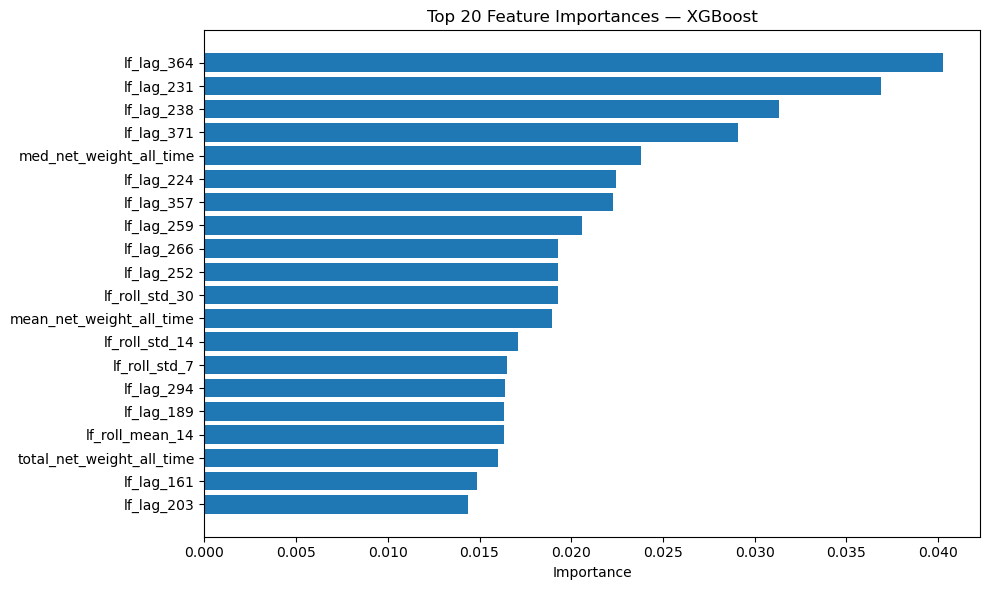

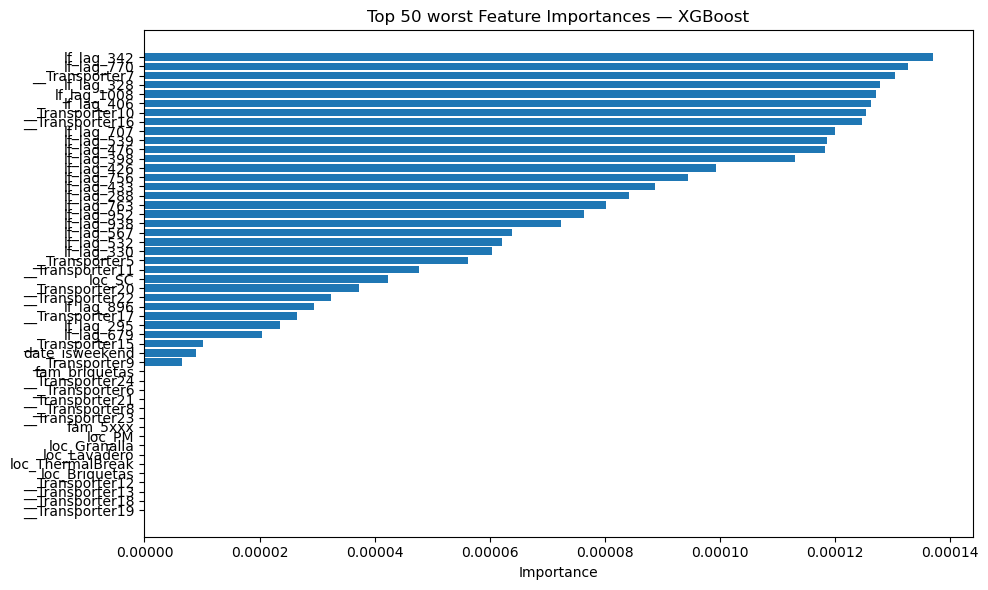

<BarContainer object of 296 artists>

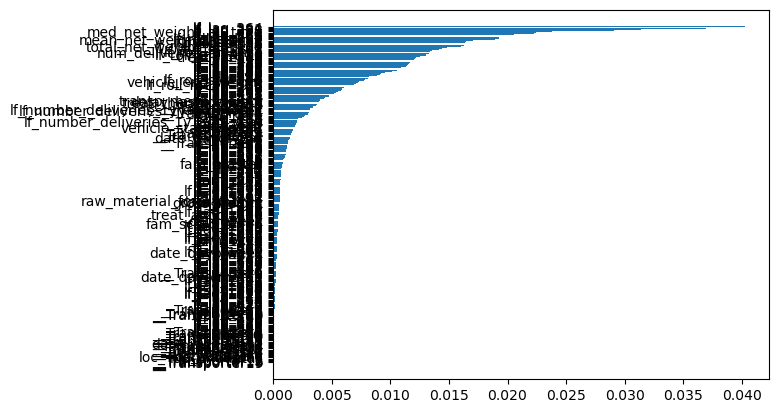

In [17]:
# plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"][:20][::-1], feat_imp["importance"][:20][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances — XGBoost")
plt.tight_layout()
plt.show()

# plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"][::-1][:50], feat_imp["importance"][::-1][:50])
plt.xlabel("Importance")
plt.title("Top 50 worst Feature Importances — XGBoost")
plt.tight_layout()
plt.show()

plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])

## 7) Forecasting

In [18]:
data_for_forecast = df_all[df_all["date"]>=pd.Timestamp("2023-01-01")].copy()
cols_to_drop = [col for col in data_for_forecast.columns
                if col.startswith("lf_")] # => all lag features
data_for_forecast = data_for_forecast.drop(columns=cols_to_drop, errors="ignore")

forecast_range = pd.date_range(forecast_start, forecast_end, freq="D", name="date")

rm_ids = pd.Index(data_for_forecast["rm_id"].unique(), name="rm_id")
static_cols = [c for c in data_for_forecast.columns
                    if c not in {"date","net_weight"} and not c.startswith(("lf_","date_"))]
static_map = (
    data_for_forecast
      .drop_duplicates(subset=["rm_id"], keep="first")[[*static_cols]]
)


multi_index = pd.MultiIndex.from_product(
    [rm_ids, forecast_range],
    names=["rm_id", "date"]
)
# Create the base DataFrame
forecast_base_df = pd.DataFrame(index=multi_index).reset_index()
forecast_base_df=create_calendar_features(forecast_base_df,'date')
forecast_base_df = forecast_base_df.merge(static_map, on="rm_id", how="left")

# attach to the base grid

data_for_forecast = pd.concat([data_for_forecast, forecast_base_df])
data_for_forecast=data_for_forecast.sort_values(["rm_id","date"]).reset_index(drop=True)
data_for_forecast= create_lag_features(data_for_forecast,removeNA=False)
input_rows = data_for_forecast.loc[
    data_for_forecast['date'] >=forecast_start,
    columns_input
    ]


In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(input_rows.shape)

print(len(df_all["rm_id"].unique()))
print(len(receivals["rm_id"].unique()))

(702348, 296)
(702348,)
(107, 296)
(107,)
(16157, 296)
107
204


In [20]:
preds = model.predict(input_rows)

data_for_forecast.loc[
    data_for_forecast['date'] >= forecast_start, 'net_weight'
] = preds

if Positive_Deliveries:
    data_for_forecast["net_weight"] = data_for_forecast["net_weight"].clip(lower=0)

# assign value 0 for the weekend
if weekend0:
    data_for_forecast.loc[data_for_forecast['date_isweekend'] == True, 'net_weight'] = 0
#------------------------ Apply a coefficient to have smaller deliveries -----------------
if weekend0:
    data_for_forecast.loc[data_for_forecast['date_isweekend'] == True, 'net_weight'] = 0

if clear_small_Deliveries:
    data_for_forecast.loc[data_for_forecast["net_weight"] < 500, "net_weight"] = 0

if clear_deliveries_because_2024_empty:
    mask_2024 = data_for_forecast["date"].between("2024-01-01", "2024-12-31")
    ids_zero_only_2024 = (
        data_for_forecast.loc[mask_2024]
        .groupby("rm_id")["net_weight"]
        .apply(lambda s: (s == 0).all())
        .pipe(lambda s: s[s].index)
    )
    print(ids_zero_only_2024)
    print(len(ids_zero_only_2024))
    data_for_forecast.loc[data_for_forecast["rm_id"].isin(ids_zero_only_2024) & (data_for_forecast["date"]>=pd.Timestamp("2025-01-01")), "net_weight"] = 0

df_pred_2025 = data_for_forecast[data_for_forecast['date'] >= forecast_start]


rm_id to test :
2121. 2123. 2124. 2125. 2129. 2130. 2131. 2132. 2133. 2134. 2135. 2138.
 2140. 2142. 2143. 2144. 2145. 2147. 2153. 2160. 2161. 2284. 2401. 2402.
 2482. 2521. 2561. 2601. 2741. 2742. 2761. 2821. 2981. 3005. 3121. 3122.
 3123. 3124. 3125. 3126. 3142. 3161. 3162. 3201. 3241. 3265. 3282. 3362.
 3381. 3421. 3441. 3601. 3621. 3642. 3701. 3761. 3762. 3781. 3841. 3865.
 3883. 3901. 3941. 4021. 4081. 4222. 4263. 4302. 4441. 4443.

 2130.0, 4263.0, 4501.0 (last rm_id)
 


## 8) Some visualisations

In [21]:
rm_ids=data_for_forecast["rm_id"].unique()[:100]
rm_ids=[ 386.0, 1875.0, 1876.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905.0, 1906.0,
       1907.0, 1908.0, 1909.0, 1982.0, 2127.0, 2138.0, 2146.0, 2149.0, 2150.0,
       2151.0, 2152.0, 2153.0, 2155.0, 2157.0, 2159.0, 2160.0, 2182.0, 2222.0,
       2261.0, 2284.0, 2364.0, 2365.0, 2401.0, 2441.0, 2482.0, 2601.0, 2761.0,
       3005.0, 3161.0, 3162.0, 3441.0, 3762.0, 3802.0, 3821.0, 3841.0, 3921.0,
       3941.0, 4101.0]
if False:
    for rm in rm_ids:
        plot_history_vs_forecast(df_all, df_pred_2025, rm, start_date="2004-01-01")

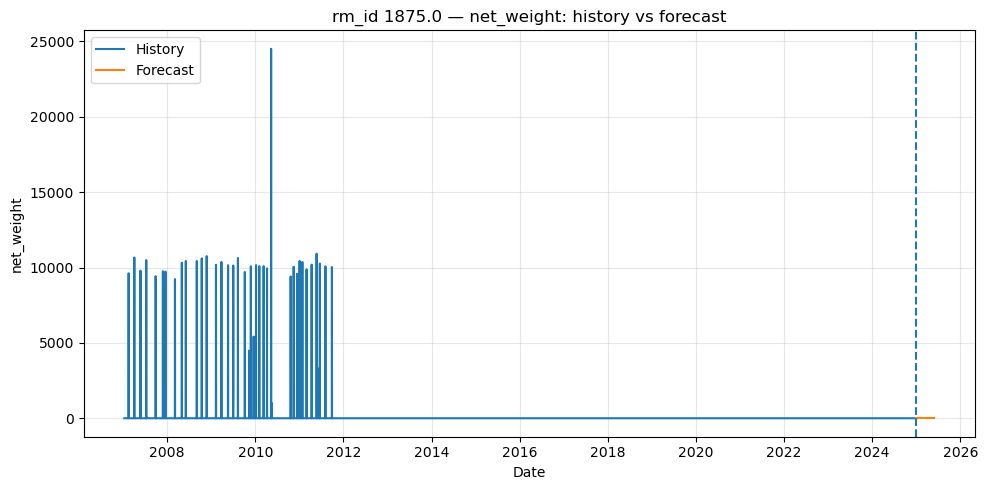

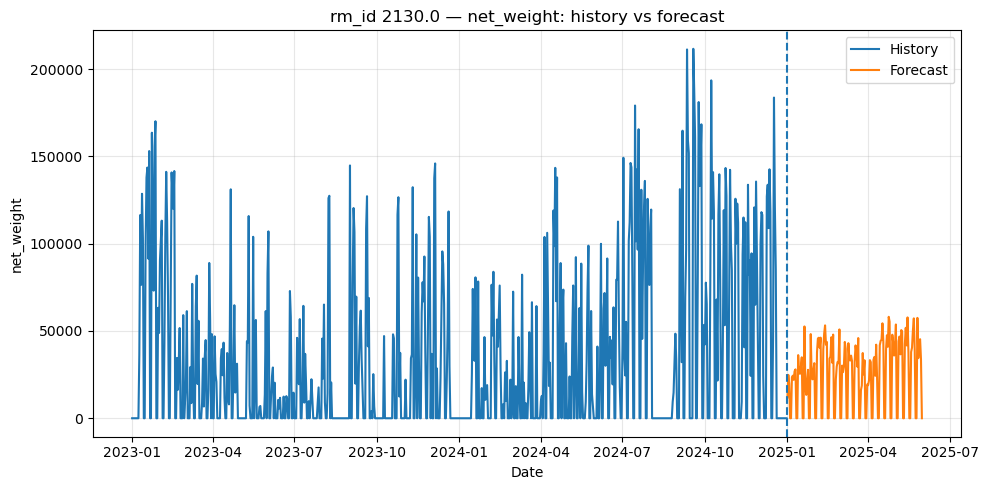

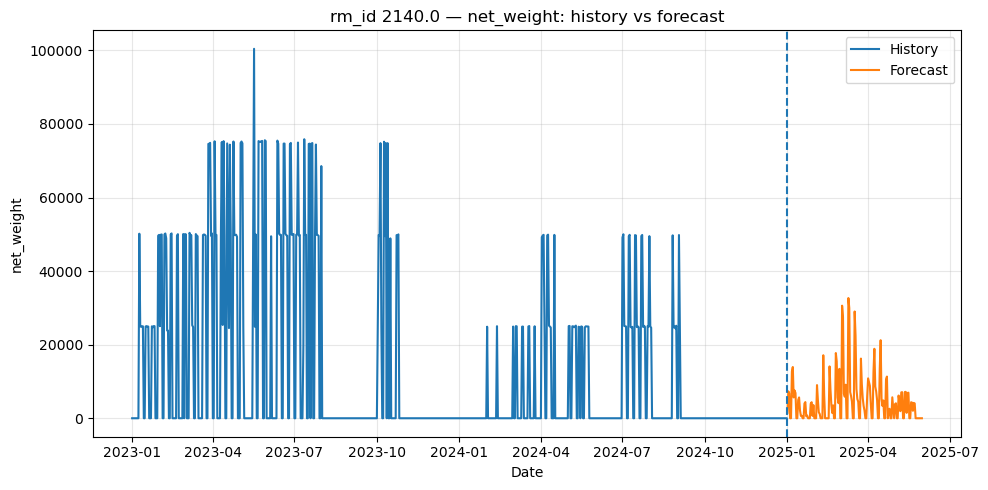

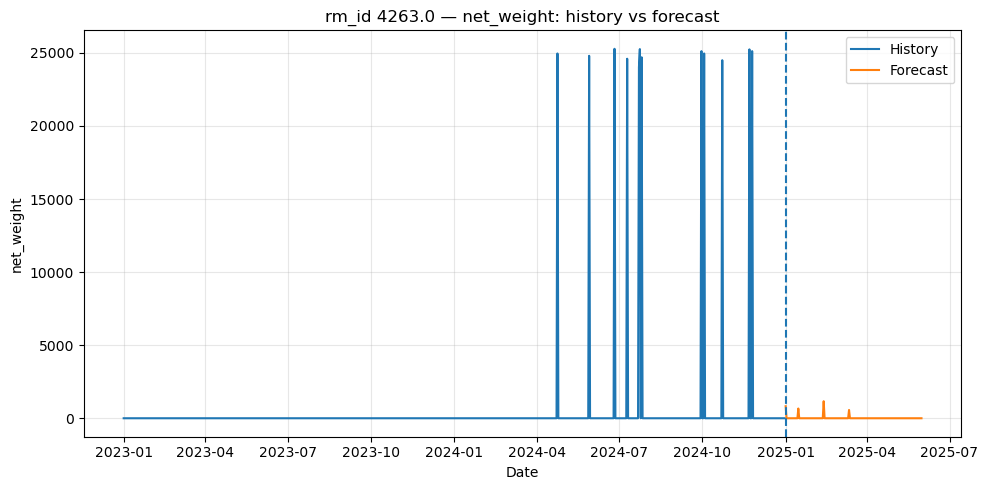

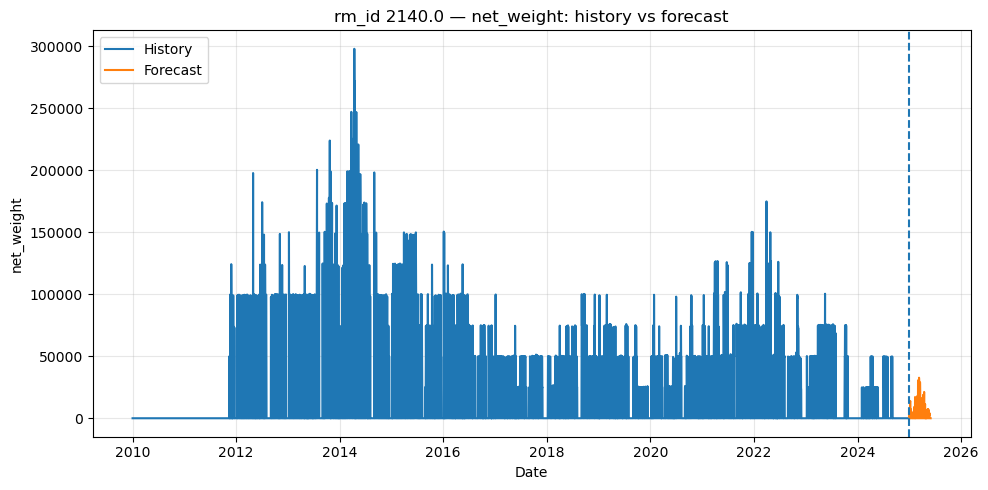

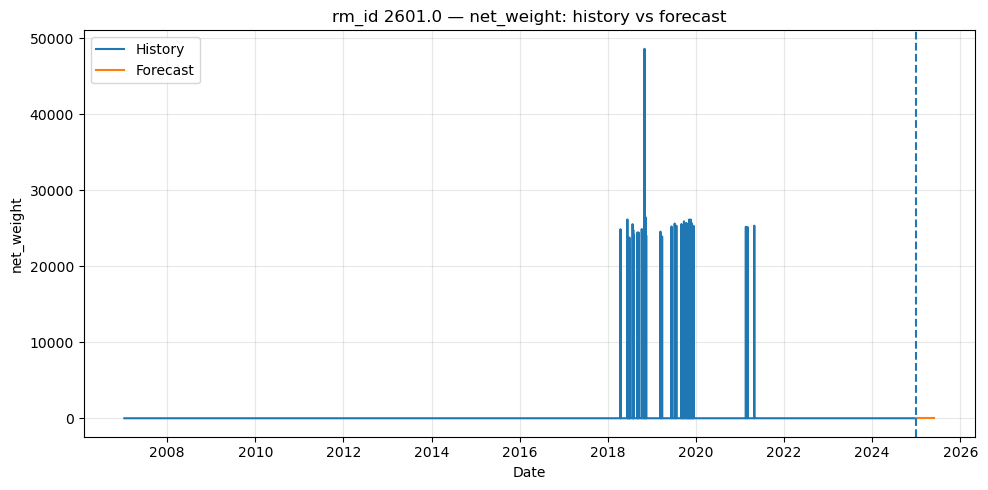

In [22]:

plot_history_vs_forecast(df_all, df_pred_2025, 1875.0,start_date="2004-01-01")
plot_history_vs_forecast(df_all, df_pred_2025, 2130.0)
plot_history_vs_forecast(df_all, df_pred_2025, 2140.0)
plot_history_vs_forecast(df_all, df_pred_2025, 4263.0)
plot_history_vs_forecast(df_all, df_pred_2025, 2140.0,start_date="2010-01-01")
plot_history_vs_forecast(df_all, df_pred_2025, 2601.0,start_date="2005-01-01")

## 9) Creation of a coefficient to have the best score and evaluate the model
idea : the score is asymetric so high predicted net_weight is bad, I would like to find the best parameter p
such that p*pred give the best score
1) I get a better score with the same model
2) I can evaluate the model : The best prediction should give a 0 at p=1 and to linear lines beforea and after 0=1
If the model is bad I will have a bad minimum and the function won't be linear everywhere : I will be above some times and under some other times.
The goal is to understand if the model predict above everytime, under everytime or both at the same time.



In [23]:
X_train_keys,X_train, y_train, X_test_keys, X_test, y_test = split_set_Train_Test(df_all, test_size=2024)
## the test set must contain only 2024 data*

C:\Users\julie\AppData\Local\Temp\ipykernel_18380\3598047402.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df_all.groupby('rm_id').apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_18380\3598047402.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = df_all.groupby('rm_id').apply(


argmin is 0.9999999999999998
min is 57288.585757501096


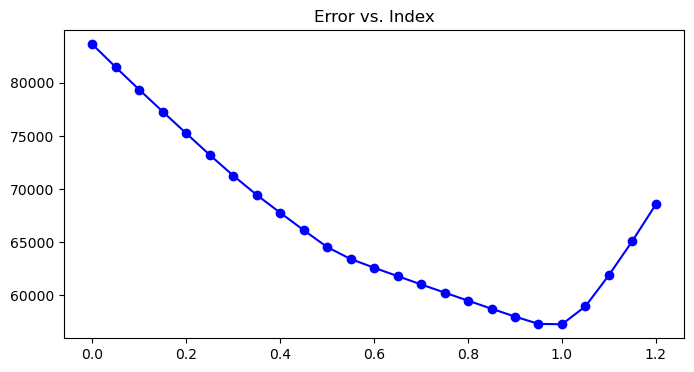

In [24]:
y_pred=model.predict(X_test)

df=X_test_keys.copy()
df["y_test"]=y_test
df["y_pred"]=y_pred

if Positive_Deliveries:
    df["y_pred"] = df["y_pred"].clip(lower=0)

# assign value 0 for the weekend

if weekend0:
    df['day_of_week'] = df['date'].dt.dayofweek
    df.loc[df['day_of_week'].isin([5, 6]), 'y_pred'] = 0
    df = df.drop(columns=['day_of_week'])


err_min=np.inf
alpha_min=1
errs=[]
for alpha in np.arange(1.2, -0.01, -0.05):
    df["y_pred"] = alpha*y_pred
    err = quantile_error_df(df)
    errs.append(err)
    if err <= err_min:
        alpha_min = alpha
        err_min=err
print(f"argmin is {alpha_min}")
print(f"min is {err_min}") # before = 57288
plt.figure(figsize=(8, 4))  # Optional: Set figure size
plt.plot(np.arange(1.2, -0.01, -0.05), errs, marker='o', linestyle='-', color='b')  # Plot with markers and line
plt.title('Error vs. Index')  # Title
plt.show()  # Display the plot



### Analyse :
The best parameter p is 1. There is a straight line after 1 and almost 2 straight lines one before 1 and one before 0.5. That means that the model predict net_weight around the right values for some rm_id but some rm_id are overestimated (because the second line is flatter than the first one(reduce the prediction is good for some rm_id) ). The minimum is 57288, that means that it still doesn't predict all deliveries and there are deliveries that are not predict at all. Deliveries that started in 2023 or 2024 are hard to use to predict 2025 because the model saw 0 most of the time. What I can tell by looking at the graphs showing the historical and the predicted deliveries is The model doesn't succeed to predict ponctual deliveries (when it happens few times a year) and new deliveries (deliveries that started after 2023).

## 10) Finalize the prediction and generate the submission

In [ ]:
#Fichier des predictions
# reduction_by_coefficient in the hyperparameters

if True:
    reduction_by_coefficient=1
    if reduction_by_coefficient !=1:
        df_pred_2025.loc[:, "net_weight"] = df_pred_2025["net_weight"] * reduction_by_coefficient



df_final_cum  = (
    df_pred_2025.groupby("rm_id", as_index=False)
        .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))
        .reset_index(drop=True)
        [["rm_id", "date", "cum"]]
)


C:\Users\julie\AppData\Local\Temp\ipykernel_18380\396753141.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))


In [27]:
print_submission(df_final_cum,filename="XGBoost-3000-0.02-8.csv")

      ID  predicted_weight
2100   1               0.0
2101   2               0.0
2102   3               0.0
2103   4               0.0
2104   5               0.0
